## Source: Dataset

In [1]:
import os
import torch
from torch.utils.data import Dataset
from torch_geometric.data import InMemoryDataset, Data
# global mean pooling and global max pooling
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_sparse import SparseTensor
import os
import pickle
import sys
import dgl
import numpy as np
import pdb
from tqdm import tqdm
from torch_geometric.data import DataLoader
import torch.nn as nn
from torch_geometric.nn import GCNConv
from sklearn.metrics import roc_auc_score, accuracy_score


# from utils.utils import get_spectral_embedding
from dgl.data import DGLDataset

from typing import Any, Dict, List, Tuple

# set the path to the root directory of the project
sys.path.append(os.path.abspath("../"))

DATA_PATH = os.path.abspath("../dataset/weifeng/all_graphs_2.pkl")
# DATA_PATH = os.path.abspath("../dataset/processed/data_dict_site16_binary.pkl")


def pre_transform(data: Dict[str, Any]) -> Data:
    """Transform the data into torch Data type"""
    if DATA_PATH == os.path.abspath("../dataset/weifeng/all_graphs_2.pkl"):
        x = data['adj']
        adj = torch.tensor(data["adj"], dtype=torch.float32)
        adj = (adj - adj.min()) / (adj.max() - adj.min())
        edge_index_ = (adj >= -1).nonzero().t().contiguous()
        edge_index_ = edge_index_[:, edge_index_[0] != edge_index_[1]]
        edge_weight = adj[edge_index_[0], edge_index_[1]]
        label = data['y'].unsqueeze(0)
        return Data(
            x=x,
            x_SC=None,
            edge_index=edge_index_,
            edge_weight=edge_weight,
            edge_index_SC=None,
            edge_weight_SC=None,
            y=label
        )
    else:
        x = torch.tensor(data["FC"], dtype=torch.float32)
        x_SC = torch.tensor(data["SC"], dtype=torch.float32)
        x_SC = (x_SC.max() - x_SC) / (x_SC.max() - x_SC.min())

        edge_index_FC = (x >= -1).nonzero().t().contiguous()
        edge_index_FC = edge_index_FC[:, edge_index_FC[0] != edge_index_FC[1]]
        row, col = edge_index_FC
        edge_weight_FC = x[row, col]

        edge_index_SC =  (x_SC > x_SC.mean()).nonzero().t().contiguous()
        edge_index_SC = edge_index_SC[:, edge_index_SC[0] != edge_index_SC[1]]
        row, col = edge_index_SC
        edge_weight_SC = torch.tensor(x_SC[row, col], dtype=torch.float32)

        feature = torch.tensor(data['feature'], dtype=torch.float32).unsqueeze(0) if 'feature' in data.keys() else None
        label_tensor = torch.tensor(data['label'], dtype=torch.float32).unsqueeze(0)


        return Data(
            x=x,
            x_SC=x_SC,
            edge_index=edge_index_FC,
            edge_weight=edge_weight_FC,
            edge_index_SC=edge_index_SC,
            edge_weight_SC=edge_weight_SC,
            y=label_tensor,
            feature=feature
        )


class Brain(InMemoryDataset):
    def __init__(
        self,
        task,
        x_attributes=None,
        processed_path="../data/processed",
        rawdata_path=DATA_PATH,
        suffix=None,
        args=None,
    ):
        
        if suffix is None:
            suffix = ""
        self.processed_path = os.path.join(processed_path, f"{task}_data{suffix}.pt")

        self.task = task
        self.x_attributes = x_attributes
        self.rawdata_path = rawdata_path
        self.suffix = suffix
        self.pre_transform = pre_transform

        super().__init__(pre_transform=self.pre_transform)

        self.data, self.slices = torch.load(self.processed_path)

        """modify"""
        # task = args.task_idx
        # task = [1]
        # self.data.y = (self.data.y)[:, task]
        """modify end"""


    def processed_file_names(self):
        return os.path.basename(self.processed_path)

    def process(self) -> None:
        with open(self.rawdata_path, "rb") as f:
            data = pickle.load(f)

        data_list = []
        for i in tqdm(range(len(data))):
            if self.pre_transform is not None:
                data_list.append(self.pre_transform(data[i]))

        self.data, self.slices = self.collate(data_list)
        print("Saving...")
        torch.save((self.data, self.slices), self.processed_path)

    @property
    def processed_dir(self):
        return os.path.dirname(self.processed_path)

    def process_data(self, data):
        data_list = []
        for i in range(len(data)):
            try:
                data_list.append(self.pre_transform(data[i]))
            except:
                pdb.set_trace()

        data, slices = self.collate(data_list)
        print("Saving...")
        torch.save((data, slices), self.processed_path)
        

dataset = Brain(task='classification', x_attributes=['adj'])

/project/uvadm/zhenyu/miniconda3/envs/brain/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Processing...
  0%|          | 0/440 [00:00<?, ?it/s]/tmp/ipykernel_159627/3318865960.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj = torch.tensor(data["adj"], dtype=torch.float32)
100%|██████████| 440/440 [00:01<00:00, 299.26it/s]


Saving...


/project/uvadm/zhenyu/miniconda3/envs/brain/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
Done!


## Main

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# get the transformed dataset
x = dataset.x.reshape(-1, 379, 379)
y = dataset.y
# y_internalizing = (y[:, 0] + y[:, 1] >= 1).long()  # Internalizing
# y_externalizing = (y[:, 2] + y[:, 3] + y[:, 4] >= 1).long()  # Externalizing
# y_HC = (torch.sum(y, dim=1) == 0).long()  # Healthy controls
# y_DX = (torch.sum(y, dim=1) > 0).long()
y = (y[:, 2] + y[:, 3] + y[:, 4] >= 1).long()
x_flat = x.reshape(x.shape[0], -1)
x_flat = x.mean(axis=1)
y_flat = y.flatten(-1)

model = LinearRegression()
model.fit(x_flat, y_flat)

# calculate R2
y_pred = model.predict(x_flat)
r2 = r2_score(y_flat, y_pred)
print(f"R2: {r2}")

R2: 0.8257957100868225


In [3]:
### Mututual Information
from sklearn.feature_selection import mutual_info_regression

mutual_info = mutual_info_regression(x_flat, y_flat)


Text(0.5, 0, 'brain region')

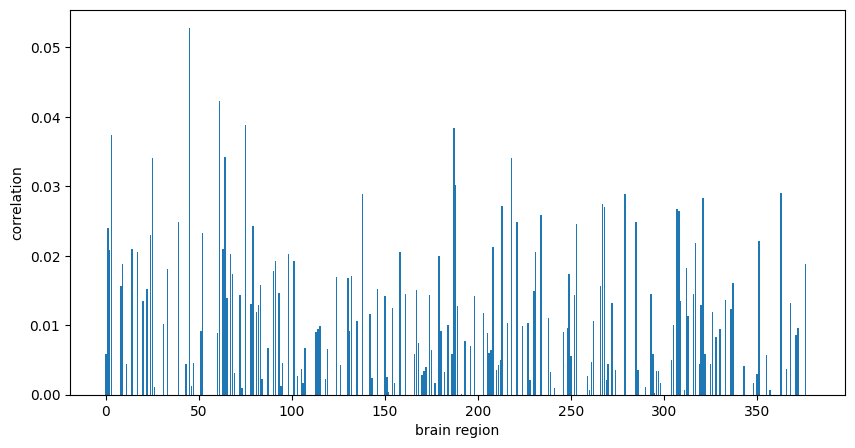

In [16]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(np.arange(len(mutual_info)), mutual_info, color='tab:blue')

ax.set_ylabel('correlation')
ax.set_xlabel('brain region')

plt.savefig

In [25]:
### Random Forest
from sklearn.ensemble import RandomForestClassifier
# raondom split
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

x = dataset.x.reshape(-1, 379, 379)
y = dataset.y
y = (y[:, 2] + y[:, 3] + y[:, 4] >= 1).long()
x_flat = x.reshape(x.shape[0], -1)
y_flat = y.flatten(-1)

x_train, x_test, y_train, y_test = train_test_split(x_flat, y_flat, test_size=0.4, random_state=42)

# data augmentation train only on the positive samples
smote = SMOTE()
x_train, y_train = smote.fit_resample(x_train, y_train)
# model
model = RandomForestClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_train)
accuracy = accuracy_score(y_train, y_pred)


In [26]:
auc = roc_auc_score(y_train, y_pred)
auc 

np.float64(1.0)

In [23]:
### SVM
from imblearn.over_sampling import SMOTE
from sklearn.svm import NuSVC
model = NuSVC()

model.fit(x_train, y_train)
y_pred = model.predict(x_train)
accuracy = accuracy_score(y_train, y_pred)
auc = roc_auc_score(y_train, y_pred)

In [24]:
auc

np.float64(0.9977777777777778)